## Download Mosaics

Use of the gdal PLMosaic driver requires specification of the planet api key. This can either be specified in the command-line options, or gdal will try to pull this from the environmental variable `PL_API_KEY`. This notebook assumes that the environmental variable `PL_API_KEY` is set. See the [gdal PLMosaic driver](https://www.gdal.org/frmt_plmosaic.html) for more information.

In [24]:
import os
import subprocess
import tempfile

from planet import api
from planet.api import downloader, filters

In [25]:
# uncomment to see what mosaics are available and to make sure the PLMosaic driver is working
# !gdalinfo "PLMosaic:"

In [26]:
# get mosaic names for July 2017 to March 2018
mosaic_dates = [('2017', '{0:02d}'.format(m)) for m in range(7, 13)] + \
               [('2018', '{0:02d}'.format(m)) for m in range(1, 4)]
mosaic_names = ['global_monthly_{}_{}_mosaic'.format(yr, mo)
                for (yr, mo) in mosaic_dates]
mosaic_output_names = [os.path.join('data', mosaic_name + '.tif')
                       for mosaic_name in mosaic_names]
for i_name, o_name in zip(mosaic_names, mosaic_output_names):
    print('{} -> {}'.format(i_name, o_name))

global_monthly_2017_07_mosaic -> data/global_monthly_2017_07_mosaic.tif
global_monthly_2017_08_mosaic -> data/global_monthly_2017_08_mosaic.tif
global_monthly_2017_09_mosaic -> data/global_monthly_2017_09_mosaic.tif
global_monthly_2017_10_mosaic -> data/global_monthly_2017_10_mosaic.tif
global_monthly_2017_11_mosaic -> data/global_monthly_2017_11_mosaic.tif
global_monthly_2017_12_mosaic -> data/global_monthly_2017_12_mosaic.tif
global_monthly_2018_01_mosaic -> data/global_monthly_2018_01_mosaic.tif
global_monthly_2018_02_mosaic -> data/global_monthly_2018_02_mosaic.tif
global_monthly_2018_03_mosaic -> data/global_monthly_2018_03_mosaic.tif


In [27]:
aoi_filename = 'pre-data/aoi.geojson'

In [28]:
def _gdalwarp(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

# lossless compression of an image
def _compress(input_filename, output_filename):
    commands = ['gdal_translate',
                '-co', 'compress=LZW',
                '-co', 'predictor=2',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

def download_mosaic(mosaic_name,
             output_filename,
             crop_filename,
             overwrite=False,
             compress=True):
    # typically gdalwarp would require `-oo API_KEY={PL_API_KEY}`
    # but if the environmental variable PL_API_KEY is set, gdal will use that
    options = ['-cutline', crop_filename, '-crop_to_cutline',
               '-oo', 'use_tiles=YES']
    
    # use PLMosaic driver
    input_name = 'PLMosaic:mosaic={}'.format(mosaic_name)
    
    # check to see if output file exists, if it does, do not warp
    if os.path.isfile(output_filename) and not overwrite:
        print('{} already exists. Aborting download of {}.'.format(output_filename, mosaic_name))
    elif compress:
        with tempfile.NamedTemporaryFile(suffix='.vrt') as vrt_file:
            options += ['-of', 'vrt']
            _gdalwarp(input_name, vrt_file.name, options)
            _compress(vrt_file.name, output_filename)
    else:
        _gdalwarp(input_name, output_filename, options)

for mosaic_name, output_filename in zip(mosaic_names, mosaic_output_names):
    download_mosaic(mosaic_name, output_filename, aoi_filename)

data/global_monthly_2017_07_mosaic.tif already exists. Aborting download of global_monthly_2017_07_mosaic.
data/global_monthly_2017_08_mosaic.tif already exists. Aborting download of global_monthly_2017_08_mosaic.
data/global_monthly_2017_09_mosaic.tif already exists. Aborting download of global_monthly_2017_09_mosaic.
data/global_monthly_2017_10_mosaic.tif already exists. Aborting download of global_monthly_2017_10_mosaic.
data/global_monthly_2017_11_mosaic.tif already exists. Aborting download of global_monthly_2017_11_mosaic.
data/global_monthly_2017_12_mosaic.tif already exists. Aborting download of global_monthly_2017_12_mosaic.
data/global_monthly_2018_01_mosaic.tif already exists. Aborting download of global_monthly_2018_01_mosaic.
data/global_monthly_2018_02_mosaic.tif already exists. Aborting download of global_monthly_2018_02_mosaic.
data/global_monthly_2018_03_mosaic.tif already exists. Aborting download of global_monthly_2018_03_mosaic.


## Classify Mosaics into Forest and Non-Forest

Although we have already performed classification of a 4-band Orthotile into forest and non-forest in [drc_roads_classification](drc_roads_classification.ipnb), the format of the data is different in mosaics, so we need to re-create our training dataset. We will use the same label images that were created as a part of that notebook. We will, however, pull a lot of code from that notebook.

In [50]:
# Import functionality from local notebooks
# from ipynb.fs.defs.drc_roads_classification import get_label_mask, get_unmasked_count

In [29]:
import os

import numpy as np
import rasterio

#### Create Label Masks

In [30]:
forest_img = os.path.join('pre-data', 'forestroad_forest.tif')
road_img = os.path.join('pre-data', 'forestroad_road.tif')

In [48]:
def get_label_mask(image_filename):
    with rasterio.open(image_filename, 'r') as src:
        band = src.read(1)
        label_data = band == 255 # valid data in white regions
        label_mask = ~label_data # mask True (masked) for not valid data
    return label_mask

def get_unmasked_count(mask):
    return np.size(mask) - np.count_nonzero(mask)

forest_mask = get_label_mask(forest_img)
print(get_unmasked_count(forest_mask))
road_mask = get_label_mask(road_img)
print(get_unmasked_count(road_mask))
forest_mask.shape

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


6652509
17219


(3333, 6008)

#### Match Images

In [39]:
image_file = mosaic_output_names[0]
image_file

'data/global_monthly_2017_07_mosaic.tif'

In [58]:
label_image = 'pre-data/roads.tif'

In [57]:
# !gdalinfo $image_file

1. Project mosaic to label crs
2. Crop mosaic to label bounds
3. Label to mosaic dimensions

In [74]:
with rasterio.open(label_image, 'r') as ref:
    dst_crs = ref.crs['init']
    (xmin, ymin, xmax, ymax) = ref.bounds
    width = ref.width
    height = ref.height

print(dst_crs)
print((xmin, ymin, xmax, ymax))
print((width, height))

epsg:32635
(324669.121082206, 113387.27147534769, 343445.6303321145, 123803.11319740933)
(6008, 3333)


In [79]:
training_file = os.path.join('data', 'mosaic_training.tif')

In [80]:
!gdalwarp -t_srs $dst_crs \
    -te $xmin $ymin $xmax $ymax \
    -ts $width $height \
    -overwrite $image_file $training_file

Using band 4 of source image as alpha.
Creating output file that is 6008P x 3333L.
Processing data/global_monthly_2017_07_mosaic.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


#### Create Training Datasets

In [81]:
from functools import reduce

from skimage import feature, filters
from sklearn.ensemble import RandomForestClassifier

In [83]:
def load_4band(filename):
    with rasterio.open(filename, 'r') as src:
        # orthotile band ordering: blue, green, red, nir
        b, g, r, n = src.read() 

        mask = b == 0 # 0 is NoData

    return [np.ma.array(band, mask=mask) for band in [b, g, r, n]]

def get_texture_features(bands):
    green_band = bands[1]
    edges1 = feature.canny(green_band, low_threshold=0.0, high_threshold=0.01, sigma=2)
    blurred = filters.gaussian(edges1, sigma=2)
    blurred2 = filters.gaussian(edges1, sigma=6)
    return [np.ma.array(texture_band, mask=green_band.mask)
            for texture_band in (blurred, blurred2)]

def get_feature_bands(image_file):
    spectral_bands = load_4band(image_file)
    texture_bands = get_texture_features(spectral_bands)
    return spectral_bands + texture_bands

feature_bands = get_feature_bands(training_file)
feature_bands[0].shape

(3333, 6008)

In [84]:
def perc_masked(mask):
    return 100*(np.count_nonzero(mask))/mask.size

def num_valid(mask):
    return (mask.size - np.count_nonzero(mask))

def combine_masks(feature_bands):
    masks = [b.mask for b in feature_bands]
    total_mask = reduce(np.logical_or, masks)
    print('{} valid pixels ({}% masked)'.format(num_valid(total_mask),
                                                round(perc_masked(total_mask), 2)))
    return total_mask

total_mask = combine_masks(feature_bands)
total_mask.shape

20001980 valid pixels (0.11% masked)


(3333, 6008)

In [86]:
def valid_pixels(band, mask):
    masked_band = np.ma.array(band, mask=mask)
    return masked_band.compressed()

def bands_to_X(feature_bands, mask):
    # X shape: (num_pixels, num_bands)
    all_valid_pixels = [valid_pixels(b, mask) for b in feature_bands]
    X = np.swapaxes(np.stack(all_valid_pixels), 0, 1)
    return X

# combine the label masks with the valid data mask and then create X dataset for each label
total_forest_mask = np.logical_or(total_mask, forest_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_forest_mask),
                                            round(perc_masked(total_forest_mask), 2)))
X_forest = bands_to_X(feature_bands, total_forest_mask)

total_road_mask = np.logical_or(total_mask, road_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_road_mask),
                                            round(perc_masked(total_road_mask), 2)))
X_road = bands_to_X(feature_bands, total_road_mask)

In [88]:
def sample_pixels(pixels, sample_size):
    if pixels.shape[0] > sample_size:
        pixel_sample = pixels.copy()
        np.random.shuffle(pixel_sample)
        pixel_sample = pixel_sample[:sample_size]
    else:
        pixel_sample = pixels
    return pixel_sample
    
def make_same_size_samples(list_of_X, size_percent=100):
    # X: array of dim (num_pixels, num_classified_bands)
    sample_len = min([p.shape[0] for p in list_of_X])

    # only return size_percent number of pixels in the sample
    if size_percent < 100 and size_percent > 0:
        sample_len = round(sample_len * size_percent/100.0)
    
    return [sample_pixels(p, sample_len) for p in list_of_X]

[X_forest_sample, X_road_sample] = \
    make_same_size_samples([X_forest, X_road], size_percent=100)

print(X_forest_sample.shape)
print(X_road_sample.shape)

(17219, 6)
(17219, 6)


In [89]:
forest_label_value = 0
road_label_value = 1
X_training = np.concatenate((X_forest_sample, X_road_sample), axis=0)
y_training = np.array(X_forest_sample.shape[0] * [forest_label_value] + \
                      X_road_sample.shape[0] * [road_label_value])
    
print(X_training.shape)
print(y_training.shape)

(34438, 6)
(34438,)


## Identify Change

In [91]:
# Simple timer to easily report processing time
import time

# inspired by https://preshing.com/20110924/timing-your-code-using-pythons-with-statement/
class Timer: 
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = int(self.end - self.start)
        print('{} seconds'.format(self.interval))

In [93]:
def classify_forest(image_file, X_training, y_training):
    clf = RandomForestClassifier()
    
    with Timer():
        clf.fit(X_training, y_training)
    
    # for random forest classification, no normalization of the features is required
    feature_bands = get_feature_bands(image_file)
    total_mask = combine_masks(feature_bands)
    X_rf = bands_to_X(feature_bands, total_mask)
    
    with Timer():
        y_pred_rf = clf.predict(X_rf)

    y_band_rf = y_to_band(y_pred_rf, total_mask)
    return y_band_rf

def y_to_band(y, mask):
    band = np.ma.array(np.zeros(mask.shape), mask=mask)
    band[~band.mask] = y
    return band

with Timer():
    y_band_rf = classify_forest(image_file, X_training, y_training)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8622399 valid pixels (0.0% masked)
5 seconds
10 seconds


In [94]:
# load local visual module
import visual

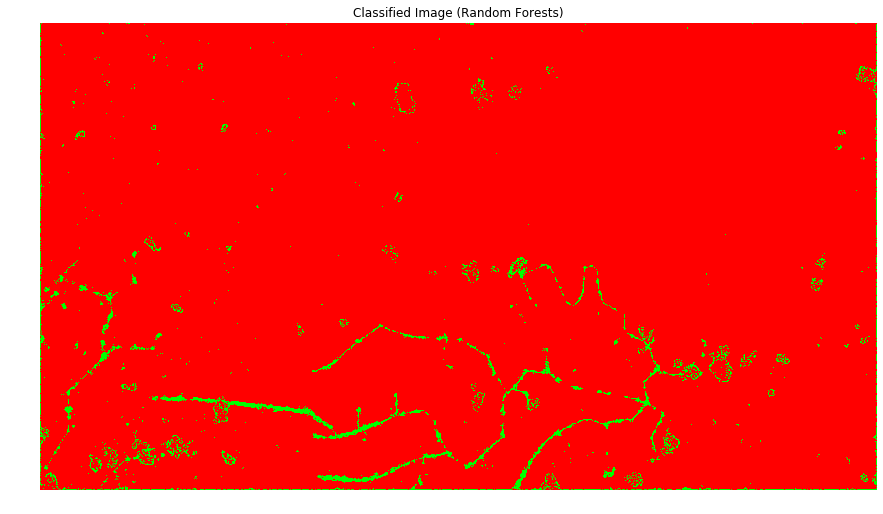

In [96]:
# separate the class numbers into rgb bands
def classified_band_to_rgb(classified_band):
    return [classified_band == n for n in [0,1,2]]

visual.plot_image(classified_band_to_rgb(y_band_rf),
                  title='Classified Image (Random Forests)',
                  figsize=(15, 15))